# **Physics Informed Neural Networks**

Physics-Informed Neural Networks (PINNs) are a class of machine learning models that integrate the physical laws governing a system, typically in the form of partial differential equations (PDEs), into the neural network's training process. This approach allows the network to learn solutions to PDEs without needing a large dataset of solution points. Instead, the PINN enforces the PDEs as constraints in the loss function, guiding the network to discover solutions that satisfy the underlying physics. This makes PINNs particularly useful for solving complex problems in fluid dynamics, heat transfer, and other fields where data may be sparse or hard to obtain. 


## Model

This notebook defines a simple PINN model using TensorFlow. The class `PINN` constructs a fully connected neural network with layers specified by `layers_dims`. Each layer uses the `tanh` activation function, except the output layer, which produces a single continuous value. The model is designed to take inputs (such as spatial and time coordinates) and return a prediction, which can be further trained to satisfy the given physical laws expressed as PDEs.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import h5py


class PINN(Model):
    def __init__(self, layers_dims):
        super(PINN, self).__init__()
        self.network = tf.keras.Sequential()
        for dim in layers_dims:
            self.network.add(layers.Dense(dim, activation="tanh"))
        self.network.add(layers.Dense(1))  

    def call(self, inputs):
        return self.network(inputs)

## Physics informed loss

A function to compute the loss for training a Physics-Informed Neural Network (PINN) to solve a partial differential equation (PDE), while enforcing initial conditions, boundary conditions, and the PDE itself.
- **Operations** : 
  1. **Gradient Calculation**: 
     - Computes the first and second derivatives of the model's output (`u`) with respect to spatial (`x`) and time (`t`) using `tf.GradientTape`.
  2. **PDE Residual**: 
     - Calculates the residual of the PDE, involving terms like `u_t`, `u_x`, and `u_xx`, which should ideally be zero for a valid solution.

- **Loss Components**:
  - **Initial Condition Loss**: 
    - Measures the difference between the model's predicted solution at `t=0` and the given `initial_condition`.
  - **Periodic Boundary Condition Loss**: 
    - Enforces periodic boundary conditions by ensuring the solution and its spatial derivative are the same at the boundary points (`x_min` and `x_max`).
  - **Residual Loss**: 
    - Penalizes deviations from the PDE's residual to ensure the model satisfies the physical equation.

- **Output**:
  - Returns the total loss, which is the sum of the initial condition loss, periodic boundary loss, and residual loss.

In [3]:
def physics_informed_loss(
    model, x, t, initial_condition, boundary_condition, du, epsilon
):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        epsilon_tensor = tf.fill(x.shape,  tf.constant(epsilon, dtype=tf.float32))
        u = model(tf.concat([x, t, epsilon_tensor], axis=1))

        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)

    residual = u_t + u * u_x - epsilon * u_xx

    # Initial condition loss
    initial_loss = tf.reduce_mean(
        tf.square(u[tf.equal(t, tf.reduce_min(t))] - initial_condition)
    )

    # Periodic boundary condition loss
    periodic_loss = tf.reduce_mean(
        tf.square(u[tf.equal(x, tf.reduce_min(x))] - u[tf.equal(x, tf.reduce_max(x))])
    ) + tf.reduce_mean(
        tf.square(
            u_x[tf.equal(x, tf.reduce_min(x))] - u_x[tf.equal(x, tf.reduce_max(x))]
        )
    )

    # Residual loss
    residual_loss = tf.reduce_mean(tf.square(residual))

    return initial_loss + periodic_loss + residual_loss

# Training Loop


- **Operations**:
  1. **Grid Creation**: 
     - Creates a mesh grid of spatial (`x_grid`) and time (`t_grid`) values, then flattens them into 1D arrays (`x_flat` and `t_flat`).
  2. **Optimizer Setup**: 
     - Uses the Adam optimizer with the specified `learning_rate` to minimize the loss.
  3. **Training Loop**: 
     - For each epoch, computes the loss using `physics_informed_loss` and updates the model parameters by computing gradients and applying them through the optimizer.


In [ ]:
def train_model(
    model,
    x,
    t,
    initial_condition,
    boundary_condition,
    du,
    epsilon,
    epochs,
    learning_rate,
):
    x_grid, t_grid = tf.meshgrid(x[:, 0], t[:, 0])  
    x_flat = tf.reshape(x_grid, [-1, 1])  
    t_flat = tf.reshape(t_grid, [-1, 1]) 

    optimizer = tf.keras.optimizers.Adam(learning_rate)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = physics_informed_loss(
                model,
                x_flat,
                t_flat,
                initial_condition,
                boundary_condition,
                du,
                epsilon,
            )
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

In [5]:
def load_data(file_name, type):
    with h5py.File(file_name, "r") as f:
        initial_condition = f[f"0/initial_condition_{type}"][:]
        boundary_condition = f[f"0/boundary_condition_{type}"][:]
        clean_data = f["0/clean"][:]
        du = f["0/du"][()]
        epsilon = f["0/epsilon"][()]
        u0 = f["0/u0"][()]
        x = f["coords/x-coordinates"][:]
        t = f["coords/t-coordinates"][:-1]
    return (
        initial_condition,
        boundary_condition,
        clean_data,
        du,
        epsilon,
        u0,
        x,
        t,
    )

In [6]:
def apply_periodic_bc(u, boundary_condition):
    """
    Enforce periodic boundary conditions on the solution.
    Args:
        u: Solution array at a given time step (tensor).
        boundary_condition: Precomputed boundary values (not directly used here).
    Returns:
        Solution array with periodic boundary applied (same shape as input).
    """
    # Update the first and last values in `u` to match the periodic boundary
    u = tf.tensor_scatter_nd_update(
        u,
        indices=[[0], [-1]],  # Indices to update: first and last points
        updates=[u[-1], u[0]],  # Periodic values: match last to first, first to last
    )
    return u

In [9]:
# Load the data
file_name = (
    "/kaggle/input/burgers-noisy/simulation_data.h5"  # Replace with your data file
)
initial_condition, boundary_condition, clean_data, du, epsilon, u0, x, t = load_data(
    file_name, "noisy"
)

x = tf.convert_to_tensor(x, dtype=tf.float32)[:, None]  # x-coordinates as column vector
t = tf.convert_to_tensor(t, dtype=tf.float32)[:, None]  # t-coordinates as column vector
initial_condition = tf.convert_to_tensor(initial_condition, dtype=tf.float32)
boundary_condition = tf.convert_to_tensor(boundary_condition, dtype=tf.float32)

layers_dims = [50, 50, 50]
epochs = 1000
learning_rate = 1e-3

model = PINN(layers_dims)

In [10]:
# Train model
train_model(
    model,
    x,
    t,
    initial_condition,
    boundary_condition,
    du,
    epsilon,
    epochs,
    learning_rate,
)

Epoch 0, Loss: 0.916638
Epoch 100, Loss: 0.430698
Epoch 200, Loss: 0.264347
Epoch 300, Loss: 0.244005
Epoch 400, Loss: 0.229778
Epoch 500, Loss: 0.220692
Epoch 600, Loss: 0.205291
Epoch 700, Loss: 0.195912
Epoch 800, Loss: 0.187993
Epoch 900, Loss: 0.181558


In [11]:
def apply_periodic_bc(u, boundary_condition):
    """
    Enforce periodic boundary conditions on the solution.
    Args:
        u: Solution array at a given time step (tensor).
        boundary_condition: Precomputed boundary values (not directly used here).
    Returns:
        Solution array with periodic boundary applied (same shape as input).
    """
    # Update the first and last values in `u` to match the periodic boundary
    u = tf.tensor_scatter_nd_update(
        u,
        indices=[[0], [-1]],  # Indices to update: first and last points
        updates=[u[-1], u[0]],  # Periodic values: match last to first, first to last
    )
    return u

In [12]:
def predict_solution_iterative(
    model, x, initial_condition, boundary_condition, epsilon, n_steps
):
    """
    Iteratively predict the solution over time.
    Args:
        model: Trained PINN model.
        x: Spatial coordinates as a tensor.
        initial_condition: Initial condition at t=0.
        boundary_condition: Boundary conditions (periodic).
        epsilon: Diffusion parameter.
        n_steps: Number of time steps to predict.
    Returns:
        Array of predictions at each time step.
    """
    dt = 1 / n_steps  # Assume uniform time step
    u = tf.convert_to_tensor(initial_condition, dtype=tf.float32)[:, None]  # Start with IC
    all_predictions = [u.numpy().reshape(-1)]
    print(u.shape)
    for _ in range(n_steps):
        # Prepare inputs for prediction
        epsilon_tensor = tf.fill(
            x.shape, tf.constant(epsilon, dtype=tf.float32)
        )  # Constant epsilon
        u_input = tf.concat([x, u], axis=1)  # Concatenate x and u
        u_input = tf.concat(
            [u_input, epsilon_tensor], axis=1
        )  # Concatenate epsilon_tensor

        # Predict next state
        u_next = model(u_input)[:, 0]  # Remove extra dimensions

        # Apply periodic boundary condition
        u_next = apply_periodic_bc(u_next, boundary_condition)

        # Store prediction and update for next step
        all_predictions.append(u_next.numpy())
        u = u_next[:, None]  # Update for next time step

    return np.array(all_predictions)

In [13]:
initial_condition, boundary_condition, clean_data, du, epsilon, u0, x, t = load_data(
    file_name, "clean"
)
x = tf.convert_to_tensor(x, dtype=tf.float32)[:, None]  # x-coordinates as column vector
t = tf.convert_to_tensor(t, dtype=tf.float32)[:, None]  # t-coordinates as column vector
initial_condition = tf.convert_to_tensor(initial_condition, dtype=tf.float32)
boundary_condition = tf.convert_to_tensor(boundary_condition, dtype=tf.float32)
n_steps = 200
predicted_solution = predict_solution_iterative(
    model,
    x=x,
    initial_condition=initial_condition,
    boundary_condition=boundary_condition,
    epsilon=epsilon,
    n_steps=n_steps,
)

print("Predicted solution shape:", predicted_solution.shape)

(1024, 1)
Predicted solution shape: (201, 1024)


100%|██████████| 201/201 [00:00<00:00, 336.12it/s]


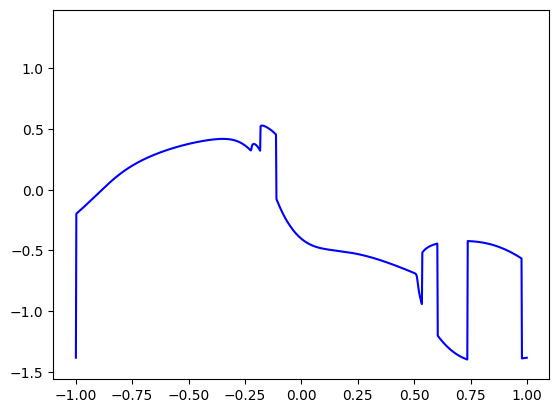

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from tqdm import tqdm


def visualize_burgers(xcrd, data):
    """
    This function animates the Burgers equation

    Args:
    path : path to the desired file
    param: PDE parameter of the data shard to be visualized
    """
    fig, ax = plt.subplots()
    ims = []

    for i in tqdm(range(data.shape[0])):
        if i == 0:
            im = ax.plot(xcrd, data[i].squeeze(), animated=True, color="blue")
        else:
            im = ax.plot(
                xcrd, data[i].squeeze(), animated=True, color="blue"
            ) 
        ims.append([im[0]])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

    writer = animation.PillowWriter(fps=15, bitrate=1800)
    ani.save("Combo.gif", writer=writer)
    plt.close(fig)
    
visualize_burgers(x, predicted_solution)

In [15]:
# Load the data
file_name = (
    "/kaggle/input/burgers-noisy/simulation_data.h5"  
)
initial_condition, boundary_condition, clean_data, du, epsilon, u0, x, t = load_data(
    file_name, "clean"
)

x = tf.convert_to_tensor(x, dtype=tf.float32)[:, None] 
t = tf.convert_to_tensor(t, dtype=tf.float32)[:, None]  
initial_condition = tf.convert_to_tensor(initial_condition, dtype=tf.float32)
boundary_condition = tf.convert_to_tensor(boundary_condition, dtype=tf.float32)

layers_dims = [50, 50, 50]
epochs = 1000
learning_rate = 1e-3

model = PINN(layers_dims)

In [16]:
# Train model
train_model(
    model,
    x,
    t,
    initial_condition,
    boundary_condition,
    du,
    epsilon,
    epochs,
    learning_rate,
)

Epoch 0, Loss: 1.849207
Epoch 100, Loss: 0.479362
Epoch 200, Loss: 0.450271
Epoch 300, Loss: 0.383433
Epoch 400, Loss: 0.171448
Epoch 500, Loss: 0.165174
Epoch 600, Loss: 0.157233
Epoch 700, Loss: 0.143543
Epoch 800, Loss: 0.129626
Epoch 900, Loss: 0.116667


In [17]:
initial_condition, boundary_condition, clean_data, du, epsilon, u0, x, t = load_data(
    file_name, "clean"
)
x = tf.convert_to_tensor(x, dtype=tf.float32)[:, None]  
t = tf.convert_to_tensor(t, dtype=tf.float32)[:, None]  
initial_condition = tf.convert_to_tensor(initial_condition, dtype=tf.float32)
boundary_condition = tf.convert_to_tensor(boundary_condition, dtype=tf.float32)
n_steps = 200
predicted_solution = predict_solution_iterative(
    model,
    x=x,
    initial_condition=initial_condition,
    boundary_condition=boundary_condition,
    epsilon=epsilon,
    n_steps=n_steps,
)

print("Predicted solution shape:", predicted_solution.shape)

(1024, 1)
Predicted solution shape: (201, 1024)


100%|██████████| 201/201 [00:00<00:00, 315.01it/s]


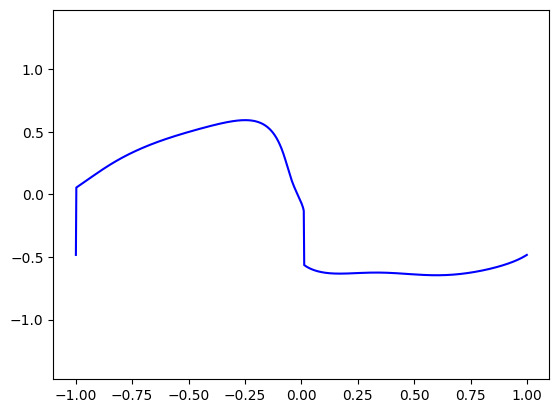

In [18]:
visualize_burgers(x, predicted_solution)